In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

In [2]:
def f(x):
    return np.exp(-x**2)

def int_trapezium(f,a,b,nint=50):
    dx = (b-a)/nint
    sigma = f(a + np.arange(1,nint,dx))
    return dx/2 * (f(a) + f(b) + 2*sum(sigma))

int_trapezium(f,-10,10)

1.7724538509055163

In [3]:
import scipy.integrate as integrate
import scipy.special as special

result = integrate.quad(lambda x: np.exp(-x**2), 0, 1)
print(result)
result = integrate.quad(lambda x: np.exp(-x**2), -np.inf, np.inf)
print(result)

(0.7468241328124271, 8.291413475940725e-15)
(1.7724538509055159, 1.4202636780944923e-08)


In [4]:
from scipy.integrate import odeint
a=1.
def pendulum(y,t):
    theta, omega = y# y = (theta,omega)
    return (omega,-a*np.sin(theta))

th0 = 90.*np.pi/180
y0 = [th0,0]
t = np.linspace(0,21,100)
y = odeint(pendulum, y0, t)

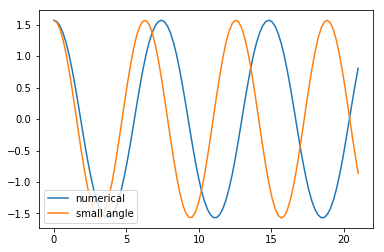

In [5]:
plt.plot(t,y[:,0],label='numerical')
plt.plot(t,th0*np.cos(np.sqrt(a)*t),label='small angle')
plt.legend(loc='lower left')
plt.show()

#Links on RCSJ model:

https://www.diva-portal.org/smash/get/diva2:560204/FULLTEXT01.pdf

https://github.com/priimak/jja

http://qutip.org/

In [6]:
# Junction parameters

r = 100
c = 1e-15
ic = 5e-6
quant = 3.29106e-16 # hbar/2e
wp = np.sqrt(ic/(quant*c))
Q = wp*r*c
print('wp='+str(wp/1e9)+', Q='+str(Q))

wp=3897.77801897, Q=0.389777801897


In [76]:
# Set up system
i = 1.005 # i_tot/i_s

def rcsj(y,t):
    # y0 = phi, y1 = phi'
    y0, y1 = y
    return (y1, -1/Q*y1 - np.sin(y0) + i)
phi0 = 0.
v0 = 0.
y0 = [phi0,v0/quant]

In [77]:
# Execute simulation
t = np.arange(0,500,0.0001)
y = odeint(rcsj, y0, t)

In [78]:
# Time integration of voltage
# use numpy's built in trapezoid-rule integration tool

voltage = np.trapz(y[:,1],t/wp)
print(voltage)

5.18238821371e-12


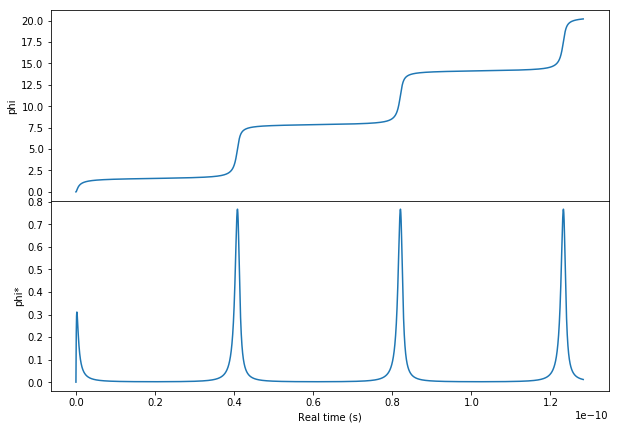

In [79]:
fig, ax = plt.subplots(2,figsize=(10,7),sharex=True)
ax[0].plot(t/wp,y[:,0])
ax[0].set_ylabel('phi')
ax[1].plot(t/wp,y[:,1])
ax[1].set_ylabel('phi*')
plt.xlabel('Real time (s)')
fig.subplots_adjust(hspace=0)
plt.show()

In [80]:
# correct integration: Should only average over one cycle
# find relative extrema
from scipy.signal import argrelextrema

In [81]:
data=y[:,1]
limit=int(-2e6)#int(-2e6)
datacrop = data[limit:]

In [91]:
%%timeit
idx=argrelextrema(datacrop, np.greater)[0]

56.8 ms ± 3.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


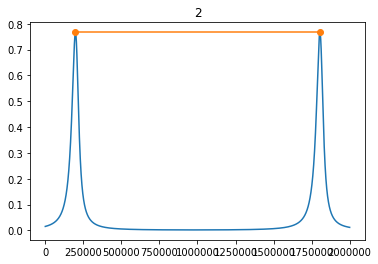

In [89]:
plt.close()
plt.plot(range(len(datacrop)),datacrop)
plt.plot(idx,datacrop[idx],'o-')
plt.title(len(idx))
plt.show()

In [84]:
# Same but with peakutils
import peakutils

In [90]:
%%timeit
idx = peakutils.indexes(datacrop, thres=0.7*max(datacrop), min_dist=1e6)

185 ms ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
# integrate using np.trapz
tidx = len(data)+limit+idx
xx = tidx[-2]
T = t[tidx[-1]]-t[tidx[-2]]
area = np.trapz(data[xx:],t[xx:])/T

In [52]:
area

0.080539207099027565

In [ ]:
voltage = []
y0 = (0,0)
dv = 0.01
for k,ii in enumerate(currents):
    i = ii
    y = odeint(rcsj, y0, t)
    y0 = y[k,:]
    idx = argrelextrema(y[-100:,0], np.greater)
    if len(idx[0])==0:
        voltage.append(0)
        #abs(y[-1,0])<=dv: # this is wrong because the oscillations might drop below dv. Rather always find relative max?
        #voltage.append((y[-1,0]))
    else:
        print(idx)
        x1, x2 = idx[0][-2], idx[0][-1]
        voltage.append(np.trapz(y[x1:x2,1],t/wp))
#print(voltage)

In [11]:
# Simulate a full IVC
# Junction parameters

r = 1000
c = 1e-15
ic = 5e-6
quant = 3.29106e-16 # hbar/2e
wp = np.sqrt(ic/(quant*c))
Q = wp*r*c
print('wp='+str(wp/1e9)+', Q='+str(Q))

wp=3897.77801897, Q=3.89777801897


In [12]:
# Currents to sweep
currents = np.arange(0.,2.1,0.01)
currents_down = currents[::-1]
all_currents = np.concatenate([currents,currents_down])
t = np.arange(0,500,0.0001)

In [13]:
voltage_up = []
y0 = (0,0)
for k,ii in enumerate(currents):
    i = ii
    y = odeint(rcsj, y0, t)
    y0 = y[k,:]
    voltage_up.append(y[-1,0])#np.trapz(y[:,1],t/wp))

In [14]:
voltage_down = []
for k,ii in enumerate(currents_down):
    i = ii
    y = odeint(rcsj, y0, t)
    y0 = y[k,:]
    voltage_down.append(y[-1,0])#np.trapz(y[:,1],t/wp))

In [15]:
all_voltage = []
y0 = (0,0)
for k,ii in enumerate(all_currents):
    i = ii
    y = odeint(rcsj, y0, t)
    y0 = y[k,:]
    all_voltage.append((y[-1,0]))#np.trapz(y[:,1],t/wp))

KeyboardInterrupt: 

In [ ]:
plt.clf()
plt.plot(all_currents,all_voltage,'.-')
plt.xlabel('I/Ic')
plt.ylabel('Voltage')
plt.title('wp='+str(wp/1e9)+', Q='+str(Q))

In [ ]:
plt.plot(voltage_up)
plt.plot(voltage_down[::-1])

In [ ]:
argrelextrema(y, np.greater)

In [ ]:
from scipy.signal import argrelextrema
x = np.linspace(10,0,11)
argrelextrema(x, np.greater)

In [ ]:
type(idx[0])

In [ ]:
a = len(idx[0])
a

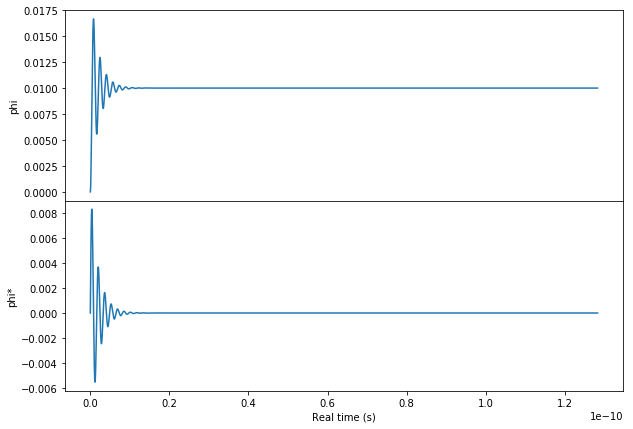

In [32]:
fig, ax = plt.subplots(2,figsize=(10,7),sharex=True)
ax[0].plot(t/wp,y[:,0])
ax[0].set_ylabel('phi')
ax[1].plot(t/wp,y[:,1])
ax[1].set_ylabel('phi*')
plt.xlabel('Real time (s)')
fig.subplots_adjust(hspace=0)
plt.show()

In [ ]:
# Code Lorenzo:
A0 = voltage - np.average(voltage)
C = A0[1:]*A0[:-1]<0 # crossings
CP = C*(A0[1:]-A0[:-1]>0) # raising crossings
period = time[CP[1]]-T[CP[0]]
